# Setting Up

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, Input, BatchNormalization, Activation, LeakyReLU
%matplotlib inline

In [3]:
tf.__version__

'1.12.0'

In [9]:
data_path = 'images\'

SyntaxError: EOL while scanning string literal (<ipython-input-9-c51aecfdba37>, line 1)

# Augmenting and Dividing the Images into Batches

In [7]:
gen = ImageDataGenerator(rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect',
    data_format='channels_last',
    brightness_range=[0.7, 1.3],
    #preprocessing_function=preprocess_input
    )

img_gen = gen.flow_from_directory(data_path, target_size = (160,128), color_mode = 'rgb', classes = None, class_mode = None, batch_size = 64, shuffle = True)

Found 0 images belonging to 0 classes.


# **Modelling the Autoencoder**

In [5]:
def make_generator():
    inp_gen = Input((160,128,3))
    x = Conv2D(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(inp_gen)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1024, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    enc = Activation('relu')(x)
    x = Conv2DTranspose(512, kernel_size = (3,3), padding = 'same', strides = (2,2))(enc)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, kernel_size = (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, kernel_size = (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(3, kernel_size = (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    out_gen = Activation('tanh')(x)
  
    model = Model(inputs = inp_gen, outputs = out_gen)
    return model

In [6]:
generator = make_generator()

In [7]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 64, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 64, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 80, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 32, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 32, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 32, 256)       0     

In [8]:
#plot_model(generator, show_shapes = True, show_layer_names = True)

# **Modelling the Discriminator**

In [9]:
def make_discriminator():
    inp_disc = Input(shape = (160,128,3))
    x = Conv2D(128, kernel_size = (3,3), strides = (2,2), padding = 'same')(inp_disc)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Conv2D(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Conv2D(512, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Conv2D(1024, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    out_disc = Activation('sigmoid')(x)

    model = Model(inputs = inp_disc, outputs = out_disc)
    return model

In [10]:
discriminator = make_discriminator()

In [11]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 64, 128)       3584      
_________________________________________________________________
batch_normalization_8 (Batch (None, 80, 64, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 32, 256)       295168    
_________________________________________________________________
batch_normalization_9 (Batch (None, 40, 32, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 32, 256)       0   

In [12]:
# plot_model(discriminator, show_shapes = True, show_layer_names = True)

# **The Loss Functions**

In [13]:
binary_loss = tf.keras.losses.BinaryCrossentropy()
mse_loss = tf.keras.losses.MeanSquaredError()

In [14]:
# disc_real_img_preds = Output by Discriminator for actual images from the Dataset
# disc_gen_img_preds = Output by Discriminator for images generated by the Generator

def discriminator_loss(disc_real_img_preds, disc_gen_img_preds):
    real_img_loss = binary_loss(tf.ones_like(disc_real_img_preds), disc_real_img_preds)
    gen_img_loss = binary_loss(tf.zeros_like(disc_gen_img_preds), disc_gen_img_preds)
    total_loss = real_img_loss + gen_img_loss
    return total_loss

In [15]:
# real_img_batch = Batch of Actual Images from the Dataset
# gen_img_batch = Batch of Images generated by the Generator

def generator_loss(disc_gen_img_preds, real_img_batch, gen_img_batch):
    gen_img_loss = binary_loss(tf.ones_like(disc_gen_img_preds), disc_gen_img_preds)
    mse = mse_loss(real_img_batch, gen_img_batch)
    total_loss = gen_img_loss + mse

    return total_loss

# **The Optimizers**

In [16]:
gen_optim = tf.keras.optimizers.Adam(0.001)
disc_optim = tf.keras.optimizers.Adam(0.001)

# **Creating Checkpoints**

In [17]:
checkpoint_directory = './training_checkpoints'
#checkpoint_directory = './350epochs ckpt backup'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optim = gen_optim,
                                 disc_optim = disc_optim,
                                 generator = generator,
                                 discriminator = discriminator)

# **Patching and Noising**

In [18]:
def patch_and_noise(real_imgs):
    # Shape of real_imgs is (1,160,128,3)
    patched_imgs = np.zeros(real_imgs.shape, dtype = np.float32)
    for i in range(real_imgs.shape[0]):
        img = real_imgs[i]
        noise = np.random.randn(160,128,3) * 20      
        noise_img = img + noise
        x = (50, 80)
        y = (50, 80)
        x1 = np.random.randint(x[0], x[1])
        x2 = np.random.randint(10, 20)
        y1 = np.random.randint(y[0], y[1])
        y2 = np.random.randint(10, 20)
        noise_img[x1:x1+x2, y1:y1+y2] = 0
        patched_imgs[i] = noise_img
    return patched_imgs

# **Standardization**

In [19]:
def standardize(imgs):
    imgs = (imgs - 127.5) / 127.5
    return tf.constant(imgs)

# **De-Standardization**

In [20]:
def destandardize(imgs):
    imgs = (imgs * 127.5) + 127.5
    imgs = tf.clip_by_value(imgs, clip_value_min = 0, clip_value_max = 255)
    return imgs

# **De-Noising Images**

In [21]:
def denoise(real_imgs):
    
    #real_imgs = next(img_gen)
    patched_imgs = patch_and_noise(real_imgs)

    patched_imgs = standardize(patched_imgs)

    generated_imgs = destandardize(generator(patched_imgs, training = False))
    patched_imgs = destandardize(patched_imgs)

    fig = plt.figure(figsize = (25,15))
    #batch_size = real_imgs.shape[0]
    batch_size = 5
    

    for i in range(batch_size):
        plt.subplot(3, batch_size, i+1)
        plt.imshow(real_imgs[i].astype(int))

        plt.subplot(3, batch_size, (i+1) + batch_size)
        plt.imshow(patched_imgs[i].numpy().astype(int))

        plt.subplot(3, batch_size, (i+1) + batch_size + batch_size)
        plt.imshow(generated_imgs[i].numpy().astype(int))
    
plt.show()       

# Save Generated Images

In [22]:
def save_generated_images(generated_images, epoch):    
    path = './saved_imgs/'
    for i in range(5):
        img = generated_images[i]
        img = img.numpy().astype('uint8')
        plt.imsave(path + "image" + str(epoch) + "_" + str(i+1) + ".jpg", img)        

# **Define Training Loop**

In [23]:
# training each batch 

#@tf.function
def train_step(real_imgs, patched_imgs):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(patched_imgs, training = True)
        disc_real_img_preds = discriminator(real_imgs, training = True)
        disc_fake_img_preds = discriminator(generated_images, training = True)

        gen_loss = generator_loss(disc_fake_img_preds, real_imgs, generated_images)
        disc_loss = discriminator_loss(disc_real_img_preds, disc_fake_img_preds)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optim.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optim.apply_gradients(zip(disc_grads, discriminator.trainable_variables))  

In [24]:
def train(img_gen, epochs, steps_per_epoch):

    for epoch in range(epochs):

        for step in tqdm(range(steps_per_epoch)):

            real_imgs = next(img_gen)
            patched_imgs = patch_and_noise(real_imgs)

            real_imgs = standardize(real_imgs)
            patched_imgs = standardize(patched_imgs)

            train_step(real_imgs, patched_imgs)

        if (epoch+1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            generated_imgs = destandardize(generator(patched_imgs, training = False))            
            save_generated_images(generated_imgs, epoch+1)
                        

        print("EPOCH {} finished".format(epoch+1))

# **Training the Model**

In [43]:
epochs = 100
steps_per_epoch = 1000 

In [44]:
train(img_gen, epochs, steps_per_epoch)


EPOCH 1 finished



EPOCH 2 finished



EPOCH 3 finished



EPOCH 4 finished



EPOCH 5 finished



EPOCH 6 finished



EPOCH 7 finished



EPOCH 8 finished



EPOCH 9 finished



EPOCH 10 finished



EPOCH 11 finished



EPOCH 12 finished



EPOCH 13 finished



EPOCH 14 finished



EPOCH 15 finished



EPOCH 16 finished



EPOCH 17 finished



EPOCH 18 finished



EPOCH 19 finished



EPOCH 20 finished



EPOCH 21 finished



EPOCH 22 finished



EPOCH 23 finished



EPOCH 24 finished



EPOCH 25 finished



EPOCH 26 finished



EPOCH 27 finished



EPOCH 28 finished



EPOCH 29 finished



EPOCH 30 finished



EPOCH 31 finished



EPOCH 32 finished



EPOCH 33 finished



EPOCH 34 finished



EPOCH 35 finished



EPOCH 36 finished



EPOCH 37 finished



EPOCH 38 finished



EPOCH 39 finished



EPOCH 40 finished



EPOCH 41 finished



EPOCH 42 finished



EPOCH 43 finished



EPOCH 44 finished



EPOCH 45 finished



EPOCH 46 finished



EPOCH 47 finished



EPOCH 48 finished



EPOCH 49 finished



EPOCH 50 finished



EPOCH 51 finished



EPOCH 52 finished



EPOCH 53 finished



EPOCH 54 finished



EPOCH 55 finished



EPOCH 56 finished



EPOCH 57 finished



EPOCH 58 finished



EPOCH 59 finished



EPOCH 60 finished



EPOCH 61 finished



EPOCH 62 finished



EPOCH 63 finished



EPOCH 64 finished



EPOCH 65 finished



EPOCH 66 finished



EPOCH 67 finished



EPOCH 68 finished



EPOCH 69 finished



EPOCH 70 finished



EPOCH 71 finished



EPOCH 72 finished



EPOCH 73 finished



EPOCH 74 finished



EPOCH 75 finished



EPOCH 76 finished



EPOCH 77 finished



EPOCH 78 finished



EPOCH 79 finished



EPOCH 80 finished



EPOCH 81 finished



EPOCH 82 finished



EPOCH 83 finished



EPOCH 84 finished



EPOCH 85 finished



EPOCH 86 finished



EPOCH 87 finished



EPOCH 88 finished



EPOCH 89 finished



EPOCH 90 finished



EPOCH 91 finished



EPOCH 92 finished



EPOCH 93 finished



EPOCH 94 finished



EPOCH 95 finished



EPOCH 96 finished



EPOCH 97 finished



EPOCH 98 finished



EPOCH 99 finished



EPOCH 100 finished


# Loading Latest Checkpoint

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

# Manually Saving the Latest Checkpoint

In [26]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints\\ckpt-53'

# Manually Saving Generated Images

In [27]:
real_imgs = next(img_gen)
patched_imgs = patch_and_noise(real_imgs)

real_imgs = standardize(real_imgs)
patched_imgs = standardize(patched_imgs)

train_step(real_imgs, patched_imgs)

generated_imgs = destandardize(generator(patched_imgs, training = False))            
save_generated_images(generated_imgs, 500)   # 350 = epoch_number

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Checking the DeNoise

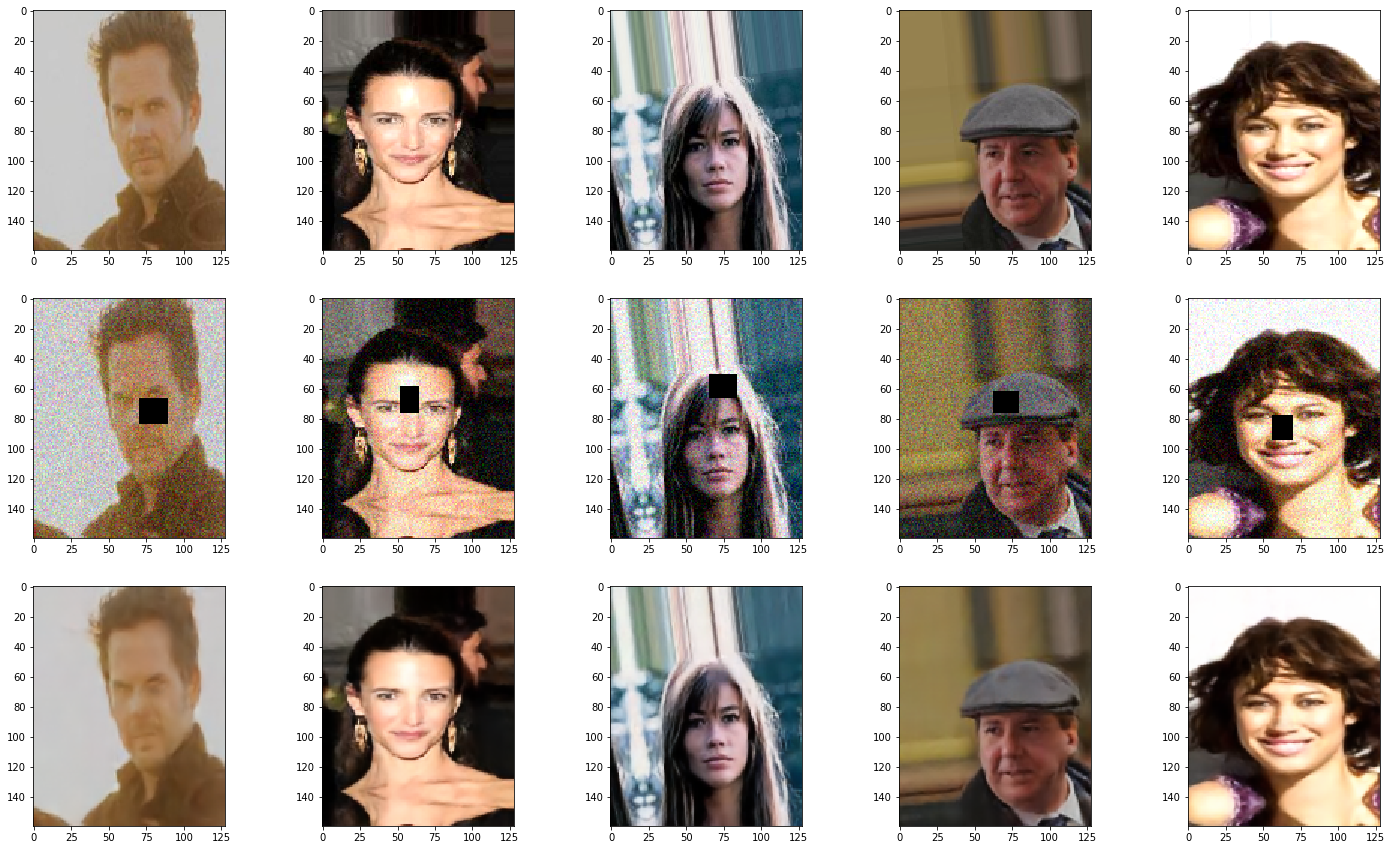

In [26]:
real_imgs = next(img_gen)
denoise(real_imgs)

# Checking the Saving of Images

In [30]:
real_imgs = next(img_gen)
real_imgs.shape

(64, 160, 128, 3)

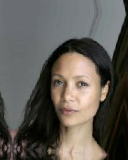

In [29]:
array_to_img(real_imgs[1])

In [32]:
patched_imgs = patch_and_noise(real_imgs)
patched_imgs.shape

(64, 160, 128, 3)

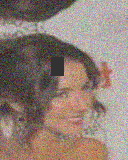

In [30]:
array_to_img(patched_imgs[1])

In [31]:
generated_imgs = destandardize(generator(standardize(patched_imgs), training = False))
generated_imgs.shape

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [35]:
save_generated_images(generated_imgs, 20)

In [39]:
disc_optim.decay

<tf.Variable 'Adam/decay:0' shape=() dtype=float32, numpy=0.0>